### Shortwave comparison: MOM6 versus POP 

This documents the behavior of showtwave radiation at the surface of the ocean as well as its absorption throught the water column. 

In [1]:
%matplotlib inline

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings, os
import matplotlib
# mom6_tools and pop-tools
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, polarplot, xyplot, xycompare, yzplot
import pop_tools
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


### MOM6

In [2]:
mom_path = '/glade/scratch/gmarques/gmom.e22.GJRAv3.TL319_t061.sw_comparison/run/'
ds_mom = xr.open_dataset(mom_path+'gmom.e22.GJRAv3.TL319_t061.sw_comparison.mom6.hm_0001.nc')
mom_hist = xr.open_mfdataset(mom_path+'gmom.e22.GJRAv3.TL319_t061.sw_comparison.cpl.hi.*nc')
grd_mom = MOM6grid(mom_path+'gmom.e22.GJRAv3.TL319_t061.sw_comparison.mom6.static.nc')

MOM6 grid successfully loaded... 



In [3]:
ds_mom_time = xr.open_dataset(mom_path+'gmom.e22.GJRAv3.TL319_t061.sw_comparison.mom6.hm_0001.nc', decode_times=False)

### POP 

In [4]:
def pop_add_cyclic(ds):

    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.

    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))

    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})

    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'),
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})


    return dso

In [5]:
grid = pop_tools.get_grid('POP_gx1v7')
grd_pop = pop_add_cyclic(grid)

In [6]:
(i_pop,j_pop)=(201,169)#, (lon,lat)=(186.6875, -4.6748)
(i_mom,j_mom)=(170,214)#, (lon,lat)=(186.6667, -4.6739)

In [7]:
print(grd_mom.geolat[j_mom,i_mom], grd_mom.geolon[j_mom,i_mom])

-4.673863761876158 -173.33333333333348


In [8]:
print(grid.TLAT[j_pop,i_pop].values, grid.TLONG[j_pop,i_pop].values)

-4.67482441632189 186.6875051950529


In [9]:
pop_path = '/glade/scratch/gmarques/gpop2.e22.GJRAv3.TL319_g16.sw_comparison/run/'
pop_hist = pop_add_cyclic(xr.open_mfdataset(pop_path+
        'gpop2.e22.GJRAv3.TL319_g16.sw_comparison.cpl.hi.*nc').rename({'x2oacc_ny': 'nlat',
                    'x2oacc_nx':'nlon'}).assign_coords({'TLAT': grid.TLAT, 'TLONG':grid.TLONG}))

pop_hist_raw = xr.open_mfdataset(pop_path+
        'gpop2.e22.GJRAv3.TL319_g16.sw_comparison.cpl.hi.*nc')
ds_pop = pop_add_cyclic(xr.open_dataset(pop_path+'gpop2.e22.GJRAv3.TL319_g16.sw_comparison.pop.h.nday1.0001-01-01.nc'))
ds_pop_raw = xr.open_dataset(pop_path+'gpop2.e22.GJRAv3.TL319_g16.sw_comparison.pop.h.nday1.0001-01-01.nc')

In [10]:
ds_pop_time = xr.open_dataset(pop_path+'gpop2.e22.GJRAv3.TL319_g16.sw_comparison.pop.h.nday1.0001-01-01.nc', decode_times=False)

### x2oacc_Foxx_swnet

(-220, 140)

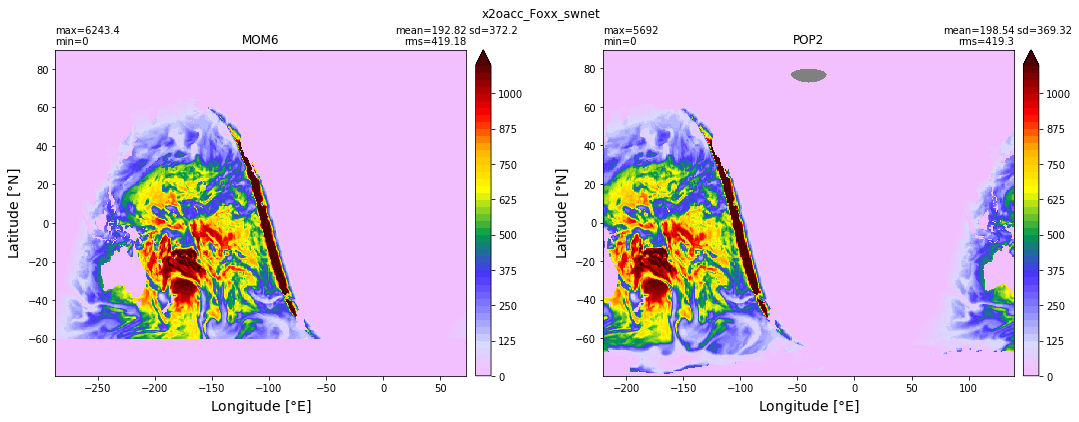

In [15]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'x2oacc_Foxx_swnet'
mom = np.ma.masked_invalid(mom_hist[variable][0,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][0,:].values)

plt.suptitle(variable)
xyplot(mom, grd_mom.geolon, grd_mom.geolat, grd_mom.area_t, title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,1082))
xyplot(pop, grd_pop.TLONG.values, grd_pop.TLAT.values, grd_pop.TAREA.values, title='POP2',
       axis=ax[1], nbins=50, clim=(0,1082))
ax[1].set_xlim(-220,140)

(-220, 140)

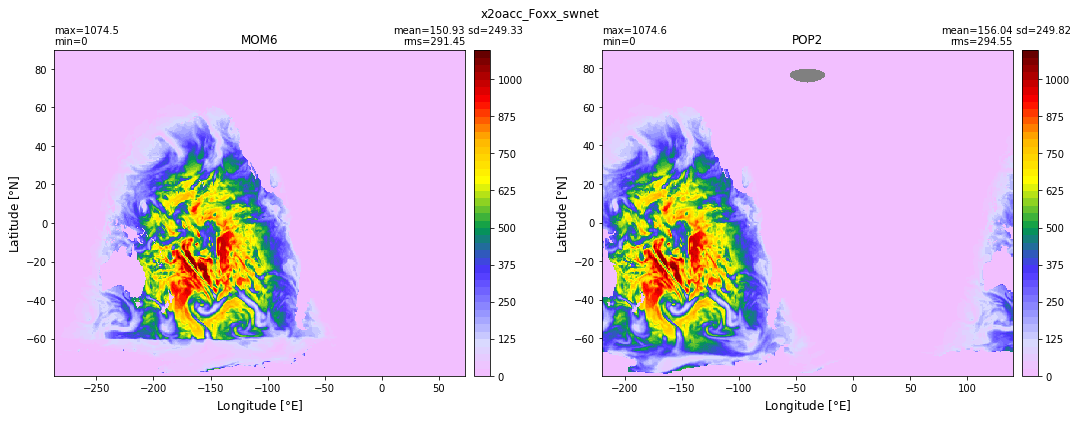

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'x2oacc_Foxx_swnet'
mom = np.ma.masked_invalid(mom_hist[variable][-1,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][-1,:].values)

plt.suptitle(variable)
xyplot(mom, grd_mom.geolon, grd_mom.geolat, grd_mom.area_t, title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,1082))
xyplot(pop, grd_pop.TLONG.values, grd_pop.TLAT.values, grd_pop.TAREA.values, title='POP2',
       axis=ax[1], nbins=50, clim=(0,1082))
ax[1].set_xlim(-220,140)

(-220, 140)

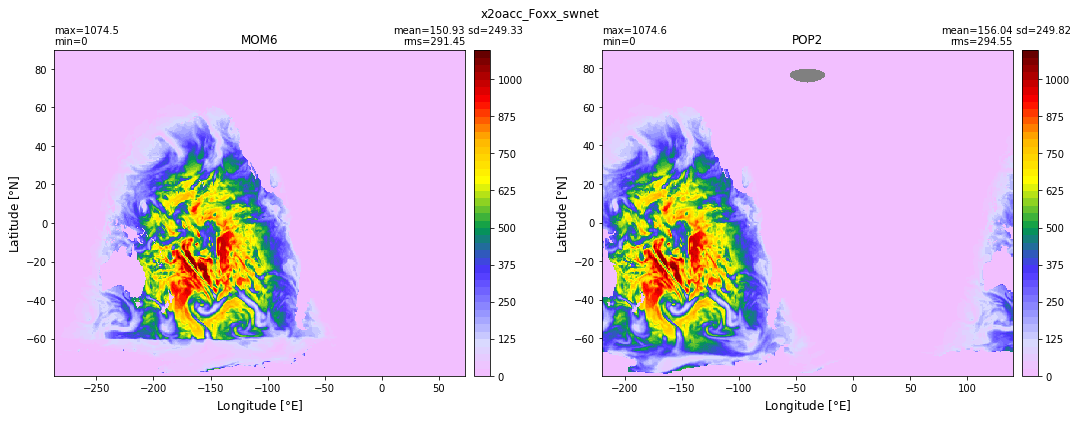

In [35]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'x2oacc_Foxx_swnet'
mom = np.ma.masked_invalid(mom_hist[variable][-1,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][-1,:].values)
plt.suptitle(variable)
xyplot(mom, grd_mom.geolon, grd_mom.geolat, grd_mom.area_t, title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,1082))
xyplot(pop, grd_pop.TLONG.values, grd_pop.TLAT.values, grd_pop.TAREA.values, title='POP2',
       axis=ax[1], nbins=50, clim=(0,1082))
ax[1].set_xlim(-220,140)

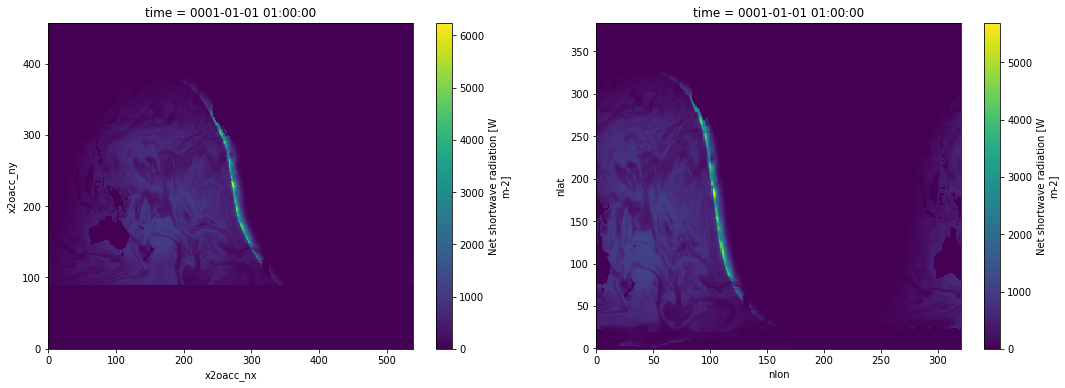

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
mom_hist[variable][0,:].plot(ax=ax[0])
pop_hist[variable][0,:].plot(ax=ax[1])

### Time series from "close" points in the MOM6 and POP2 grids

In [37]:
print(grd_mom.geolat[j_mom,i_mom], grd_mom.geolon[j_mom,i_mom])

-4.673863761876158 -173.33333333333348


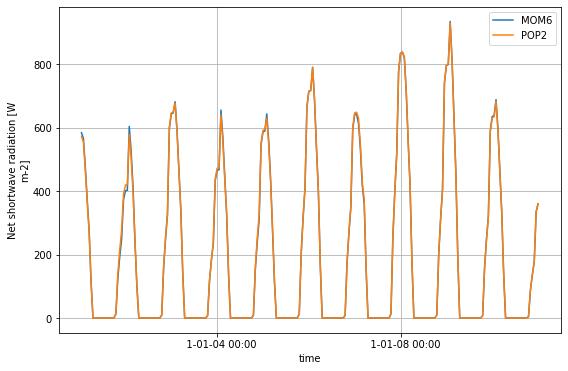

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plt.title('MOM6 versus POP2')
mom_hist[variable][:,j_mom, i_mom].plot(ax=ax, label='MOM6')
pop_hist_raw[variable][:,j_pop, i_pop].plot(ax=ax, label='POP2')
ax.legend()
ax.grid()

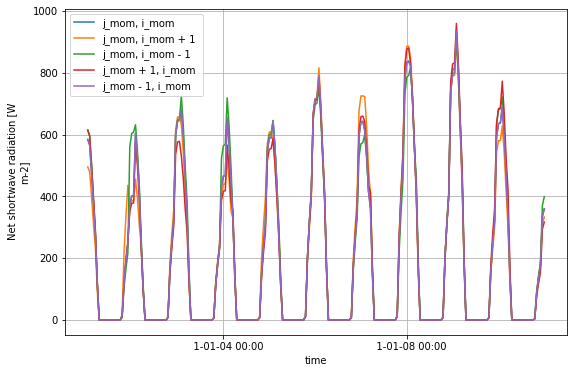

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plt.title('MOM6:neighboring points')
mom_hist[variable][:,j_mom, i_mom].plot(ax=ax, label='j_mom, i_mom')
mom_hist[variable][:,j_mom, i_mom+ 1].plot(ax=ax, label='j_mom, i_mom + 1')
mom_hist[variable][:,j_mom, i_mom- 1].plot(ax=ax, label='j_mom, i_mom - 1')
mom_hist[variable][:,j_mom+1, i_mom].plot(ax=ax, label='j_mom + 1, i_mom ')
mom_hist[variable][:,j_mom-1, i_mom].plot(ax=ax, label='j_mom - 1, i_mom ')
ax.legend()
ax.grid()

### x2oacc_Faxa_lwdn

(-220, 140)

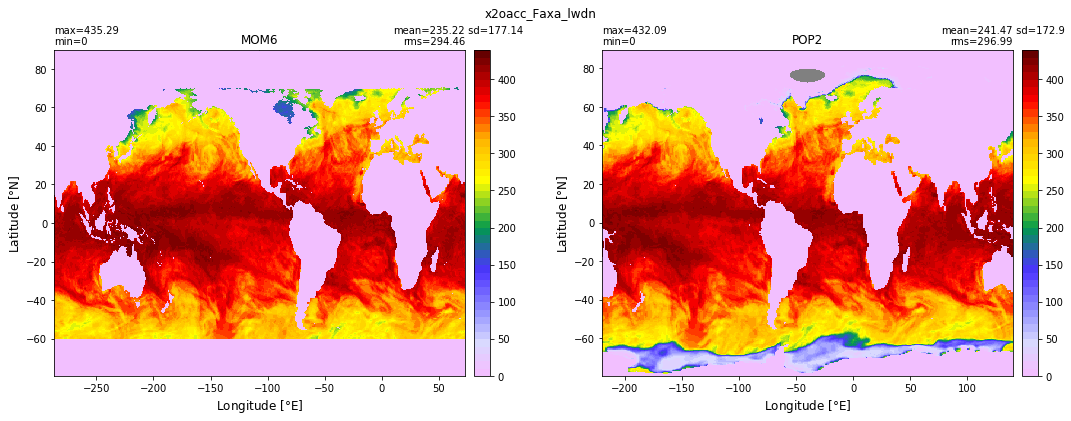

In [21]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'x2oacc_Faxa_lwdn'
mom = np.ma.masked_invalid(mom_hist[variable][0,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][0,:].values)
plt.suptitle(variable)
xyplot(mom, grd_mom.geolon, grd_mom.geolat, grd_mom.area_t, title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,432))
xyplot(pop, grd_pop.TLONG.values, grd_pop.TLAT.values, grd_pop.TAREA.values, title='POP2',
       axis=ax[1], nbins=50, clim=(0,432))
ax[1].set_xlim(-220,140)

### x2oacc_Faxa_prec

(-220, 140)

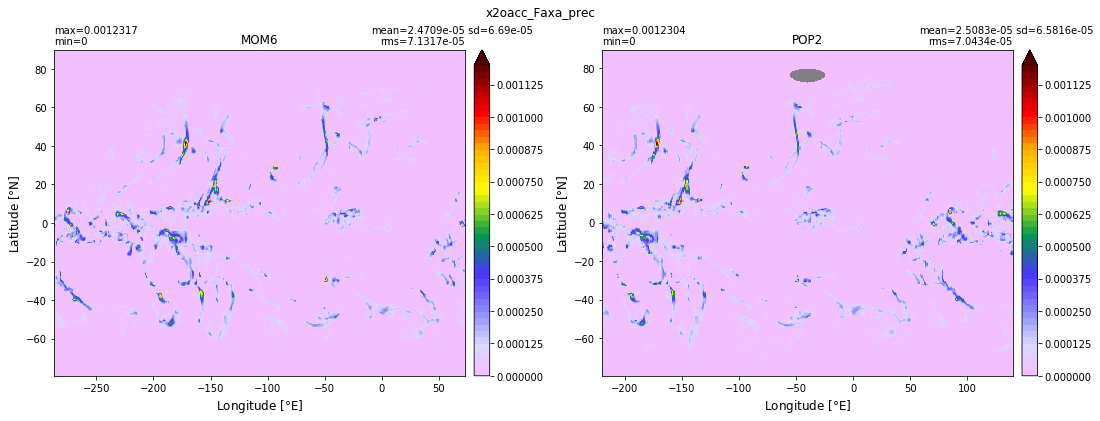

In [22]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'x2oacc_Faxa_prec'
mom = np.ma.masked_invalid(mom_hist[variable][0,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][0,:].values)
plt.suptitle(variable)
xyplot(mom, grd_mom.geolon, grd_mom.geolat, grd_mom.area_t, title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,1.2e-3))
xyplot(pop, grd_pop.TLONG.values, grd_pop.TLAT.values, grd_pop.TAREA.values, title='POP2',
       axis=ax[1], nbins=50, clim=(0,1.2e-3))
ax[1].set_xlim(-220,140)

### x2oacc_Foxx_lwup

(-220, 140)

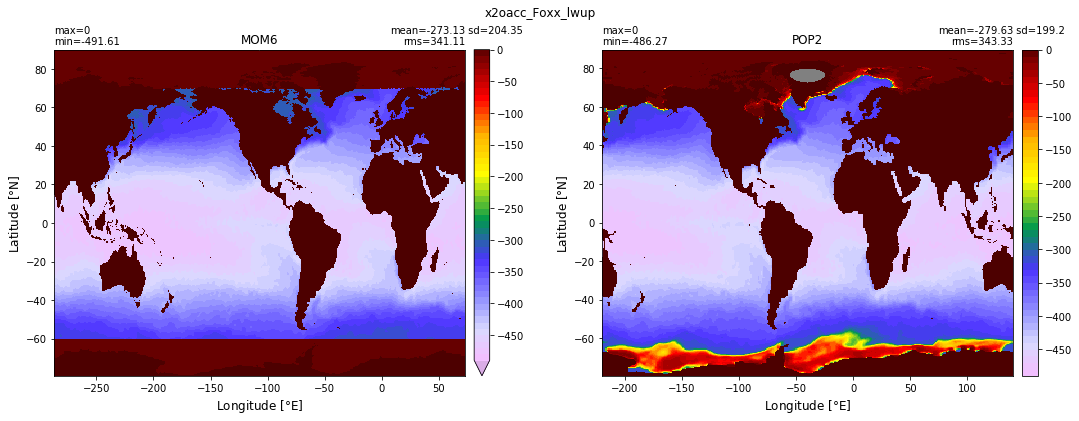

In [23]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'x2oacc_Foxx_lwup'
mom = np.ma.masked_invalid(mom_hist[variable][0,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][0,:].values)
plt.suptitle(variable)
xyplot(mom, grd_mom.geolon, grd_mom.geolat, grd_mom.area_t, title='MOM6', 
       axis=ax[0], nbins=50, clim=(-490,0.))
xyplot(pop, grd_pop.TLONG.values, grd_pop.TLAT.values, grd_pop.TAREA.values, title='POP2',
       axis=ax[1], nbins=50, clim=(-490,0))
ax[1].set_xlim(-220,140)

### xaoo_So_avsdr

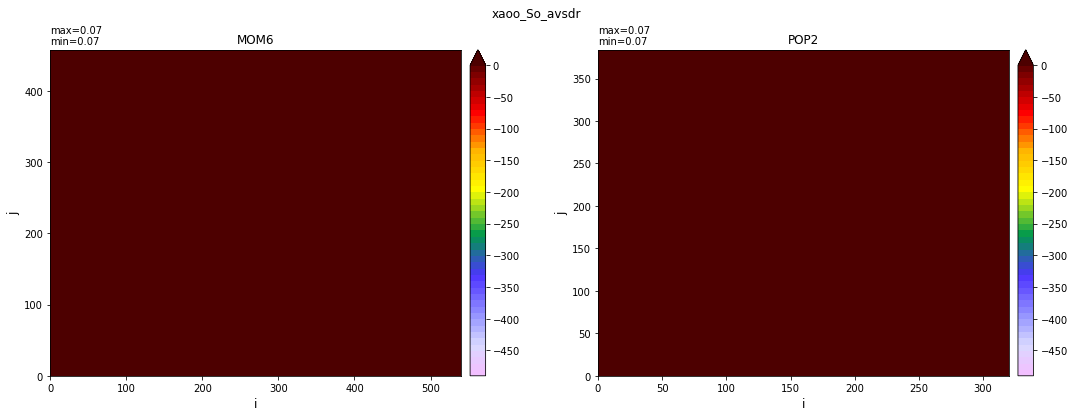

In [24]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'xaoo_So_avsdr'
mom = np.ma.masked_invalid(mom_hist[variable][0,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][0,:].values)
plt.suptitle(variable)
xyplot(mom, title='MOM6', 
       axis=ax[0], nbins=50, clim=(-490,0.))
xyplot(pop,  title='POP2',
       axis=ax[1], nbins=50, clim=(-490,0))

### a2x_Faxa_swvdr

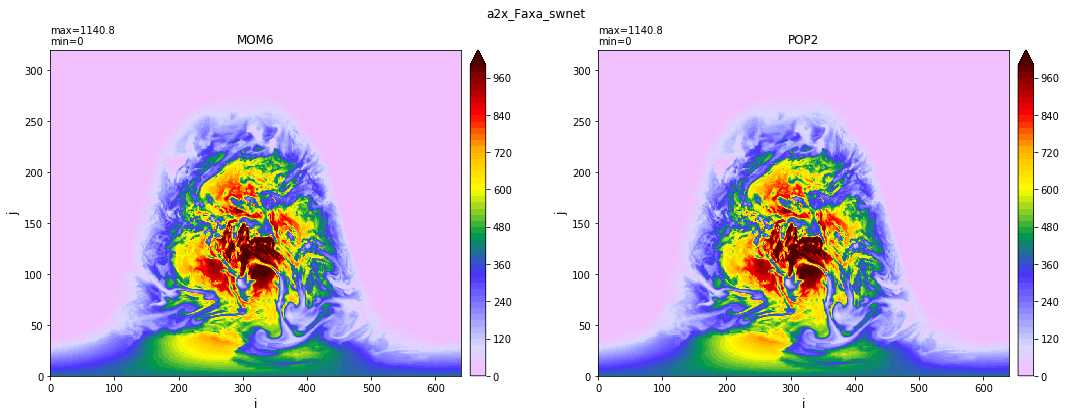

In [25]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'a2x_Faxa_swnet'
mom = np.ma.masked_invalid(mom_hist[variable][0,:].values)
pop = np.ma.masked_invalid(pop_hist[variable][0,:].values)
plt.suptitle(variable)
xyplot(mom,  title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,1000))
xyplot(pop, title='POP2',
       axis=ax[1], nbins=50, clim=(0,1000))
#ax[1].set_xlim(-220,140)

In [26]:
### a2x_Faxa_lwdn

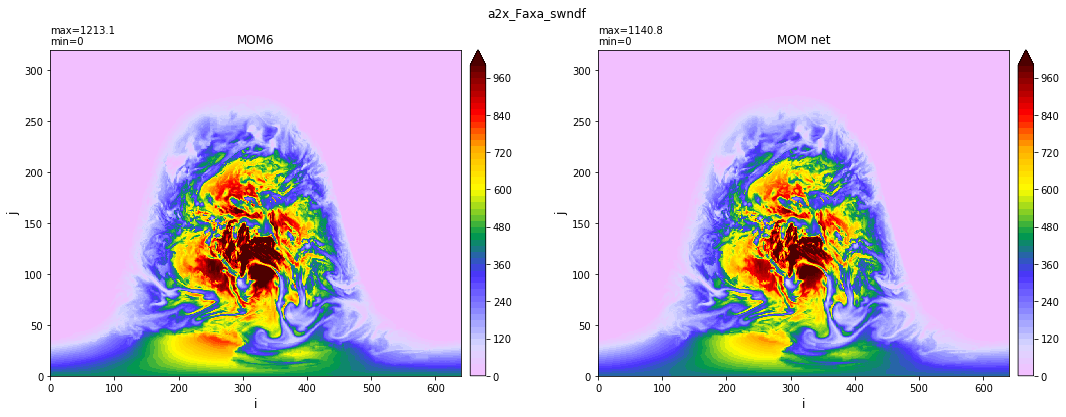

In [27]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variable = 'a2x_Faxa_swndf'
mom = np.ma.masked_invalid(mom_hist['a2x_Faxa_swndf'][0,:].values +
                          mom_hist['a2x_Faxa_swvdf'][0,:].values +
                          mom_hist['a2x_Faxa_swvdr'][0,:].values +
                          mom_hist['a2x_Faxa_swndr'][0,:].values)
mom_net = np.ma.masked_invalid(mom_hist['a2x_Faxa_swnet'][0,:].values)

plt.suptitle(variable)
xyplot(mom,  title='MOM6', 
       axis=ax[0], nbins=50, clim=(0,1000))
xyplot(mom_net, title='MOM net',
       axis=ax[1], nbins=50, clim=(0,1000))
#ax[1].set_xlim(-220,140)